In [1]:
# Optimized & faster run (reduced iterations and incremental tracking of filled cells)
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt

A = 10.0
DOMAIN_MIN, DOMAIN_MAX = -5.12, 5.12

def fitness(x: np.ndarray) -> float:
    x1, x2 = x
    return - (A*2 + (x1**2 - A*math.cos(2*math.pi*x1)) + (x2**2 - A*math.cos(2*math.pi*x2)))

def behavior_descriptor(x: np.ndarray) -> np.ndarray:
    return x.copy()

BINS_PER_DIM = 50
INIT_SAMPLES = 1500
ITERATIONS = 8000
MUTATION_SIGMA = 0.2
RNG = np.random.default_rng(42)

bin_edges = np.linspace(DOMAIN_MIN, DOMAIN_MAX, BINS_PER_DIM + 1)
def discretize(bvec: np.ndarray):
    i = max(0, min(BINS_PER_DIM - 1, int(np.digitize(bvec[0], bin_edges) - 1)))
    j = max(0, min(BINS_PER_DIM - 1, int(np.digitize(bvec[1], bin_edges) - 1)))
    return (i, j)

fitness_grid = np.full((BINS_PER_DIM, BINS_PER_DIM), np.nan, dtype=float)
genotype_grid = [[None for _ in range(BINS_PER_DIM)] for _ in range(BINS_PER_DIM)]
filled_cells = []  # incremental cache of filled indices
filled_mask = np.zeros((BINS_PER_DIM, BINS_PER_DIM), dtype=bool)

def insert_into_archive(x: np.ndarray, f: float):
    i, j = discretize(behavior_descriptor(x))
    current = fitness_grid[i, j]
    if np.isnan(current):
        fitness_grid[i, j] = f
        genotype_grid[i][j] = x.copy()
        filled_cells.append((i, j))
        filled_mask[i, j] = True
        return True
    elif f > current:
        fitness_grid[i, j] = f
        genotype_grid[i][j] = x.copy()
        return True
    return False

def random_solution():
    return RNG.uniform(DOMAIN_MIN, DOMAIN_MAX, size=2)

def mutate(x: np.ndarray):
    child = x + RNG.normal(0.0, MUTATION_SIGMA, size=x.shape)
    return np.clip(child, DOMAIN_MIN, DOMAIN_MAX)

# Initialization
for _ in range(INIT_SAMPLES):
    x = random_solution()
    f = fitness(x)
    insert_into_archive(x, f)

# Evolutionary loop
for _ in range(ITERATIONS):
    if filled_cells:
        i, j = random.choice(filled_cells)
        parent = genotype_grid[i][j]
        if parent is None:
            parent = random_solution()
    else:
        parent = random_solution()
    child = mutate(parent)
    f = fitness(child)
    insert_into_archive(child, f)

# Reporting
filled_count = int(np.count_nonzero(~np.isnan(fitness_grid)))
coverage = filled_count / (BINS_PER_DIM * BINS_PER_DIM)
best_f = float(np.nanmax(fitness_grid))
best_cell = np.unravel_index(np.nanargmax(fitness_grid), fitness_grid.shape)
best_x = genotype_grid[best_cell[0]][best_cell[1]]

print(f"Archive coverage: {coverage*100:.2f}% ({filled_count}/{BINS_PER_DIM*BINS_PER_DIM})")
print(f"Best elite fitness: {best_f:.4f} at cell {best_cell} with genotype {best_x}")

Archive coverage: 96.08% (2402/2500)
Best elite fitness: -0.7452 at cell (np.int64(25), np.int64(25)) with genotype [0.02943935 0.05403568]


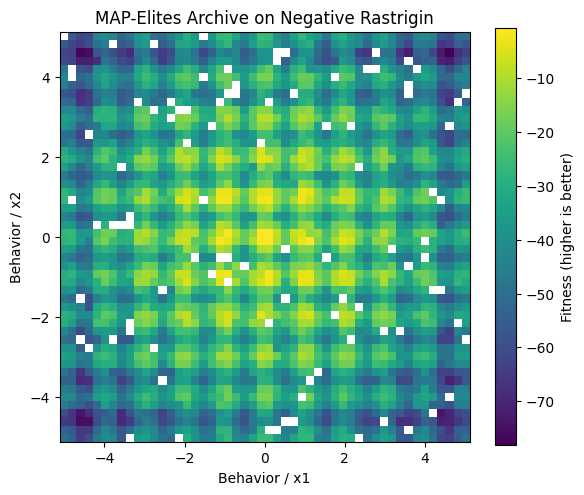

In [2]:
# Visualization (single plot)
plt.figure(figsize=(6,5))
im = plt.imshow(fitness_grid.T, origin="lower",
                extent=[DOMAIN_MIN, DOMAIN_MAX, DOMAIN_MIN, DOMAIN_MAX],
                interpolation="nearest")
plt.colorbar(im, label="Fitness (higher is better)")
plt.xlabel("Behavior / x1")
plt.ylabel("Behavior / x2")
plt.title("MAP-Elites Archive on Negative Rastrigin")
plt.tight_layout()
plt.show()